# Resolution Parameters

First, mount drive

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername of the unzipped folder
FOLDERNAME = 'unet-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/unet-master


Let's focus on image 8.png for these comparison resolution tests

Import the necessary info for the Model - And I know this should have just gone in a separate file but I had to edit something in Data.py so it works

In [9]:
#Model

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model




Import more necessary functions

In [10]:
#Data (without param parts)

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,width,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"{size}_predict.png".format(size = width)),img)

We'll now output several predicted maps of the original grain image, changing the dimension with each image

In [12]:
widths = [] #Store various image sizes you want to test

for x in range (1,9):
  widths.append(32*4*x)
print("selected image output sizes:",widths)

#You need the image size to be a multiple of 2^5 = 32 because of the way/ number of times the layers pool

def dimension_comparison(widths):
  for w in widths:
    #Define the generator to the correct size
    def testGenerator(test_path,num_image = 30,target_size = (w,w),flag_multi_class = False,as_gray = True):
      for i in range(num_image):
          img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          yield img

    #Do the testing on each image
    testGene = testGenerator("data/resolution_test")
    model = unet(input_size=(w,w,1)) #
    model.load_weights("2000-3-weights.hdf5")
    results = 255 * model.predict_generator(testGene, 1, verbose=1)
    saveResult("data/resolution_test", str(w), results.astype('uint8'))

#widths = []
#widths = [1024]

dimension_comparison(widths)

selected image output sizes: [128, 256, 384, 512, 640, 768, 896, 1024]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1/1 [==============================] - 20s 20s/step


Let's now define some post processing functions

In [13]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

#post_process('data/test/0_predict.png', thresh=250, verbose=True)


Produce thresh skeletonized processed versions of all images

In [16]:
test_dir = 'data/resolution_test/'

for i in widths: 
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=253)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

Display processed in a subplot

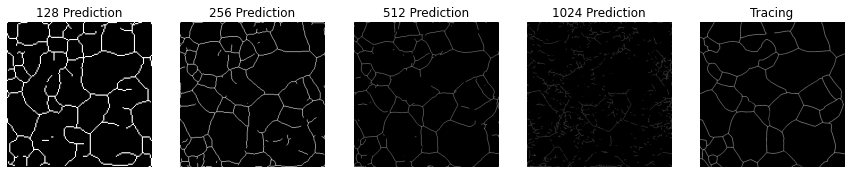

In [23]:
# Display

# Import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read images

reservoir = [('data/resolution_test/128_processed.png','128 Prediction'),
             ('data/resolution_test/256_processed.png','256 Prediction'),
             ('data/resolution_test/512_processed.png','512 Prediction'),
             ('data/resolution_test/1024_processed.png','1024 Prediction'),
             ('data/resolution_test/Traced.png','Tracing')]

# Set your canvas (fig) and the number of axes (images) you want to display
#axs = (ax1,ax2,ax3,ax4,ax5)
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(15,10))

for n in range(0,5):
  path, title = reservoir[n]

  image = mpimg.imread(path)
  axs[n].imshow(image, cmap='gray')
  axs[n].set_title(title)
  axs[n].axis('off')

'''
img1 = mpimg.imread('data/resolution_test/128_processed.png')
img2 = mpimg.imread('data/resolution_test/256_processed.png')
img3 = mpimg.imread('data/resolution_test/512_processed.png')
img4 = mpimg.imread('data/resolution_test/1024_processed.png')
img5 = mpimg.imread('data/resolution_test/Traced.png')


ax1.imshow(img1, cmap='gray')
ax1.set_title("128")
ax1.axis('off')
ax2.imshow(img2, cmap='gray')
ax2.set_title("256")
ax2.axis('off')
ax3.imshow(img3, cmap='gray')
ax3.set_title("512")
ax3.axis('off')
ax4.imshow(img4, cmap='gray')
ax4.set_title("1024")
ax4.axis('off')
ax5.imshow(img5, cmap='gray')
ax5.set_title("Tracing")
ax5.axis('off')
'''

plt.show()


Overlayment: Generate images of the predict and trace maps overlayed on the originals

In [40]:
from PIL import Image
import numpy as np

def overlay(front_path,
            back_path,
            color):
  
  img = Image.open(front_path)
  background = Image.open(back_path)

  img = img.convert("RGBA")
  background = background.convert("RGBA")

  #Optional Color Exchange Step:
  pixdata = img.load()
  width, height = img.size
  for y in range(height):
      for x in range(width):
          if pixdata[x, y] == (255, 255, 255, 255): #FROM White
              if color == 'red':
                pixdata[x, y] = (255, 0, 0, 255) #TO Red
              if color == 'green':
                pixdata[x, y] = (0, 255, 0, 255) #TO Green
              if color == 'blue':
                pixdata[x, y] = (0, 0, 255, 255) #TO Blue

          #This step makes the black background transparent so you can see the original through it
          if pixdata[x, y] == (0, 0, 0, 255): #FROM Black
              pixdata[x, y] = (0, 0, 0, 0) #TO Transparency

  # Downsample the background to fit gen map
  size = img.size
  background = background.resize(size,Image.ANTIALIAS)

  background.paste(img, (0, 0), img)

  return background


test_dir = 'data/resolution_test/'

# First put trace on orig in blue
front_path = 'data/resolution_test/Traced.png'
back_path = 'data/resolution_test/0.png'
traceover = np.array(overlay(front_path,back_path,'blue'))
io.imsave('data/resolution_test/traceover.png', traceover.astype('uint8'))

for i in [128,256,512,1024]:
  #PART I
  # Put predict on orig
  front_path = f'{test_dir}{i}_processed.png'
  back_path = 'data/resolution_test/0.png'
  over = np.array(overlay(front_path,back_path,'red'))
  io.imsave(f'{test_dir}{i}_predict_on_orig.png', over.astype('uint8'))

  #PART II
  # Put predict on traceover (= trace on orig)
  front_path = f'{test_dir}{i}_processed.png'
  back_path = 'data/resolution_test/traceover.png'
  over = np.array(overlay(front_path,back_path,'red'))
  io.imsave(f'{test_dir}{i}_both_on_orig.png', over.astype('uint8'))


Visualize the results

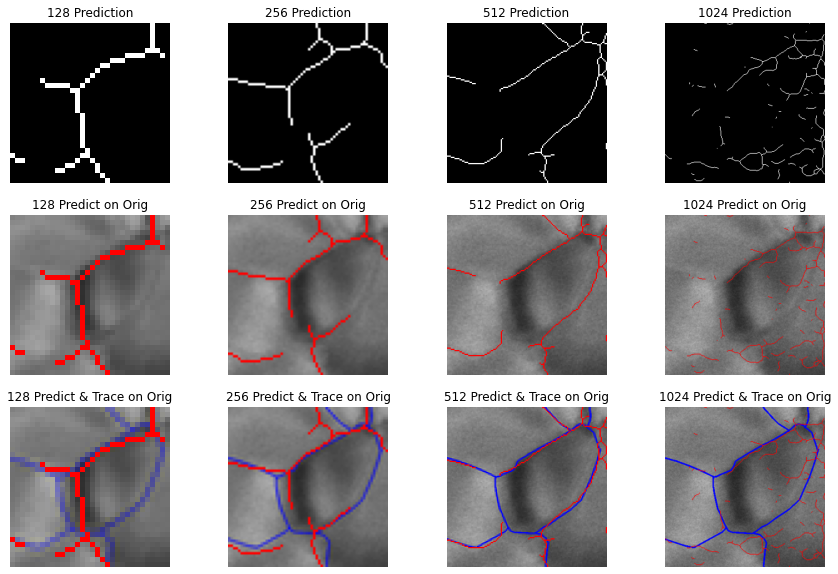

In [46]:
# Display

# Import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read images

reservoir = [
              [('data/resolution_test/128_processed.png','128 Prediction'),
              ('data/resolution_test/256_processed.png','256 Prediction'),
              ('data/resolution_test/512_processed.png','512 Prediction'),
              ('data/resolution_test/1024_processed.png','1024 Prediction')],
             
              [('data/resolution_test/128_predict_on_orig.png','128 Predict on Orig'),
              ('data/resolution_test/256_predict_on_orig.png','256 Predict on Orig'),
              ('data/resolution_test/512_predict_on_orig.png','512 Predict on Orig'),
              ('data/resolution_test/1024_predict_on_orig.png','1024 Predict on Orig')],
             
              [('data/resolution_test/128_both_on_orig.png','128 Predict & Trace on Orig'),
              ('data/resolution_test/256_both_on_orig.png','256 Predict & Trace on Orig'),
              ('data/resolution_test/512_both_on_orig.png','512 Predict & Trace on Orig'),
              ('data/resolution_test/1024_both_on_orig.png','1024 Predict & Trace on Orig')]
             ]

# Set your canvas (fig) and the number of axes (images) you want to display
fig, axs = plt.subplots(nrows=3,ncols=4,figsize=(15,10))

for j in range(0,4):
  for i in range(0,3):
    path, title = reservoir[i][j]

    image = mpimg.imread(path)

    #This section lets you zoom in on a 1/16th of the image 
    # so you can better see what's going on
    size = image.shape[0]
    w = int(size/4)
    n = 2
    m = 3
    image = image[n*w:(n+1)*w,m*w:(m+1)*w]

    # n = 2, m = 3 gives a great comparison point full grain

    axs[i][j].imshow(image, cmap='gray')
    axs[i][j].set_title(title)
    axs[i][j].axis('off')


plt.savefig('foo.png', bbox_inches='tight')

Adding Chi 2 values to the mix (unfinished)

In [33]:
from chi2test import *

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

img1 = mpimg.imread('data/resolution_test/256_processed.png')
img2 = mpimg.imread('data/resolution_test/Traced.png')

#Make both the same size
image_resized = resize(img2, (img1.shape[0],img1.shape[1]), anti_aliasing=True)

find_chi2(img1,img2)

0